In [1]:
import os, sys, numpy as np, time, random, concurrent.futures
import matplotlib.pyplot as plt

# Set up source paths (adjust as necessary)
notebooks_path = os.path.abspath(os.getcwd())
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import your custom functions (including markovian ones) from files.
from optimal_code.utils import *
from optimal_code.optimal_solver import *
from optimal_code.optimal_solver_markov import *

In [3]:

T = 30
L_X = np.tril(np.ones((T, T)))      # For process X: all ones
L_Y = np.tril(np.ones((T, T)))*np.sqrt(4)



sample_sizes = [25000, 50000, 75000, 100000, 200000, 300000, 400000]
fixed_grid = 0.2
n_runs = 10
seed1 = np.random.randint(10000)
seed2 = np.random.randint(10000)
X_sim, A = Lmatrix2paths(L_X, 1, seed=seed1, verbose=False)
Y_sim, B = Lmatrix2paths(L_Y, 1, seed=seed2, verbose=False)

print(adapted_wasserstein_squared(A, B))

465.0


In [15]:
results = {}

for n_sample in sample_sizes:
    benchmark = adapted_wasserstein_squared(A, B)
    
    distances_runs = np.zeros(n_runs)
    times_runs = np.zeros(n_runs)
    
    print(f"\nRunning experiments for sample size: {n_sample}")
    for run in range(n_runs):
        # Use two different random seeds for the two processes
        seed = np.random.randint(10000)
        
        # Generate sample paths using the matrix representations
        X_sim, A_sim = Lmatrix2paths(L_X, n_sample, seed=seed, verbose=False)
        Y_sim, B_sim = Lmatrix2paths(L_Y, n_sample, seed=seed, verbose=False)
        
        # Convert to adapted paths using fixed grid quantization
        adaptedX = path2adaptedpath(X_sim, delta_n=fixed_grid)
        adaptedY = path2adaptedpath(Y_sim, delta_n=fixed_grid)
        
        # Build quantization mapping
        q2v = np.unique(np.concatenate([adaptedX, adaptedY], axis=0))
        v2q = {k: v for v, k in enumerate(q2v)}
        qX = np.array([[v2q[x] for x in y] for y in adaptedX])
        qY = np.array([[v2q[x] for x in y] for y in adaptedY])
        qX = sort_qpath(qX.T)
        qY = sort_qpath(qY.T)
        
        # Build conditional measures (markovian)
        mu_x = qpath2mu_x(qX, markovian=True)
        nu_y = qpath2mu_x(qY, markovian=True)
        
        # Updated list representations now return 7 items:
        (mu_x_c, mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn, v2q_x, mu_x_idx) = \
            list_repr_mu_x_markovian(mu_x, q2v)
        (nu_y_c, nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn, v2q_y, nu_y_idx) = \
            list_repr_mu_x_markovian(nu_y, q2v)
        
        # Compute adapted Wasserstein squared distance using the updated parallel solver
        t_start = time.perf_counter()
        AW_2square = nested2_parallel_markovian(mu_x_cn, mu_x_v, mu_x_w, mu_x_idx,
                                                nu_y_cn, nu_y_v, nu_y_w, nu_y_idx,
                                                n_processes=42)
        elapsed = time.perf_counter() - t_start
        
        distances_runs[run] = AW_2square
        times_runs[run] = elapsed
        
        print(f"Sample size {n_sample}, Run {run+1}: AW_2^2 = {AW_2square:.4f}, Time = {elapsed:.4f} s")
    
    results[n_sample] = {"distances": distances_runs,
                         "times": times_runs,
                         "benchmark": benchmark}







Running experiments for sample size: 25000
Sample size 25000, Run 1: AW_2^2 = 492.5963, Time = 26.6719 s
Sample size 25000, Run 2: AW_2^2 = 498.0259, Time = 25.3381 s
Sample size 25000, Run 3: AW_2^2 = 486.9336, Time = 26.2130 s
Sample size 25000, Run 4: AW_2^2 = 493.8230, Time = 30.4791 s
Sample size 25000, Run 5: AW_2^2 = 497.6648, Time = 29.4118 s
Sample size 25000, Run 6: AW_2^2 = 489.8260, Time = 31.8228 s
Sample size 25000, Run 7: AW_2^2 = 491.0879, Time = 30.4207 s
Sample size 25000, Run 8: AW_2^2 = 484.4405, Time = 29.9092 s
Sample size 25000, Run 9: AW_2^2 = 483.7233, Time = 30.5393 s
Sample size 25000, Run 10: AW_2^2 = 492.9343, Time = 29.1453 s

Running experiments for sample size: 50000
Sample size 50000, Run 1: AW_2^2 = 479.8280, Time = 21.8813 s
Sample size 50000, Run 2: AW_2^2 = 480.7024, Time = 22.6489 s
Sample size 50000, Run 3: AW_2^2 = 476.7873, Time = 22.0248 s
Sample size 50000, Run 4: AW_2^2 = 480.0723, Time = 22.1577 s
Sample size 50000, Run 5: AW_2^2 = 475.5333


Aggregated Results:
Sample Size: 25000
  Mean AW_2^2: 491.1056 ± 4.7099
  Mean Time: 28.9951 s ± 2.0532 s
  Mean Absolute Error: 26.1056 ± 4.7099
  Benchmark: 465.0000

Sample Size: 50000
  Mean AW_2^2: 479.8992 ± 3.4364
  Mean Time: 24.0748 s ± 3.7520 s
  Mean Absolute Error: 14.8992 ± 3.4364
  Benchmark: 465.0000

Sample Size: 75000
  Mean AW_2^2: 476.2186 ± 0.6288
  Mean Time: 31.9374 s ± 5.3945 s
  Mean Absolute Error: 11.2186 ± 0.6288
  Benchmark: 465.0000

Sample Size: 100000
  Mean AW_2^2: 476.1601 ± 1.6126
  Mean Time: 28.5444 s ± 4.4779 s
  Mean Absolute Error: 11.1601 ± 1.6126
  Benchmark: 465.0000

Sample Size: 200000
  Mean AW_2^2: 472.7138 ± 1.3345
  Mean Time: 38.5346 s ± 1.6283 s
  Mean Absolute Error: 7.7138 ± 1.3345
  Benchmark: 465.0000

Sample Size: 300000
  Mean AW_2^2: 471.4589 ± 0.6415
  Mean Time: 40.7957 s ± 1.6651 s
  Mean Absolute Error: 6.4589 ± 0.6415
  Benchmark: 465.0000

Sample Size: 400000
  Mean AW_2^2: 470.9376 ± 0.8689
  Mean Time: 34.6614 s ± 6.0309

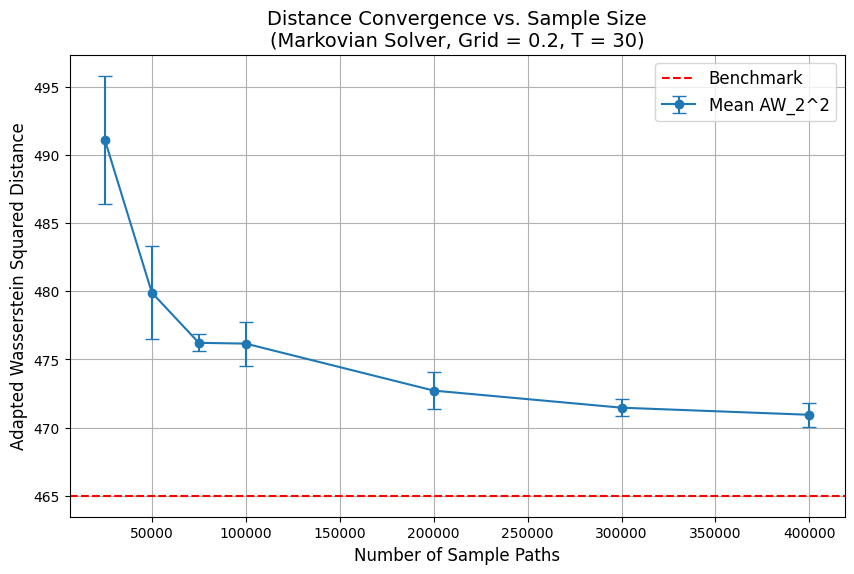

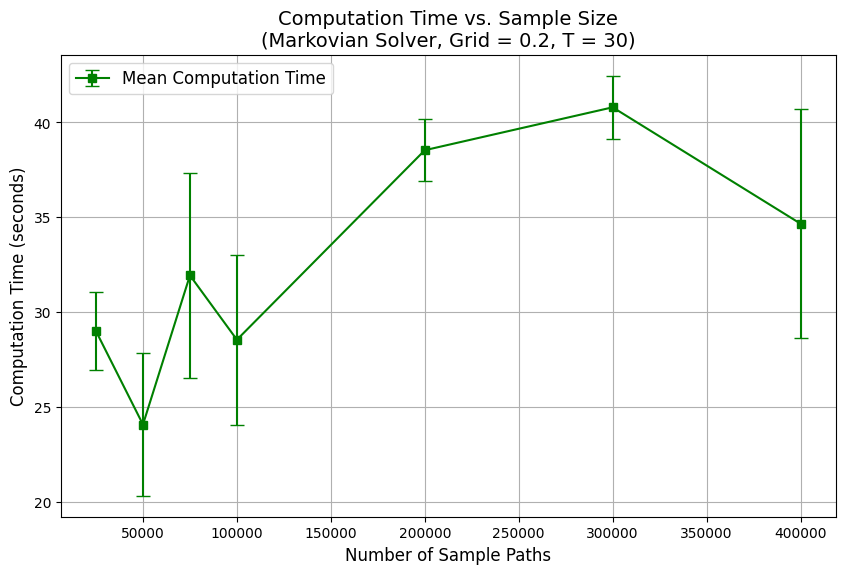

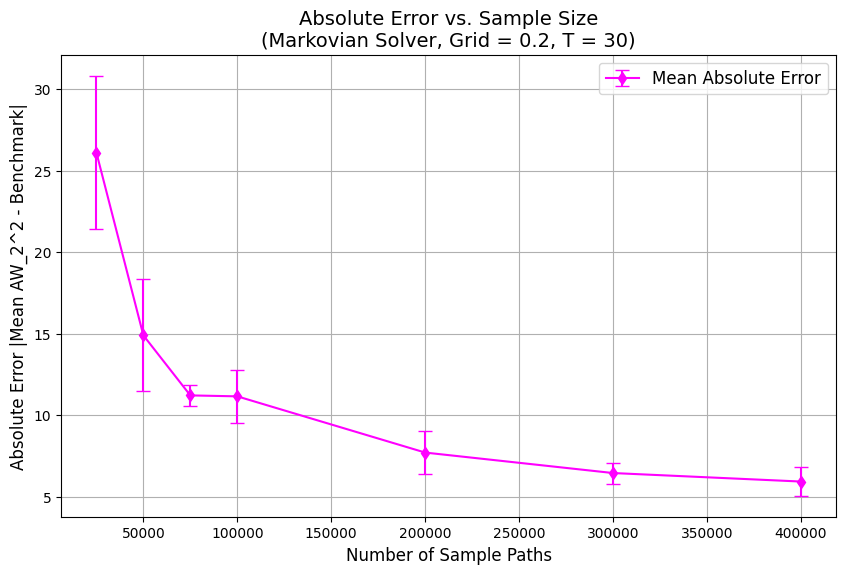

In [17]:

print("\nAggregated Results:")
aggregated = {}
for n_sample in sorted(results.keys()):
    data = results[n_sample]
    dists = data["distances"]
    times = data["times"]
    bench = data["benchmark"]
    mean_dist = np.mean(dists)
    std_dist = np.std(dists)
    mean_time = np.mean(times)
    std_time = np.std(times)
    abs_errors = np.abs(dists - bench)
    mean_abs_err = np.mean(abs_errors)
    std_abs_err = np.std(abs_errors)
    aggregated[n_sample] = {
        "mean_distance": mean_dist,
        "std_distance": std_dist,
        "mean_time": mean_time,
        "std_time": std_time,
        "mean_abs_error": mean_abs_err,
        "std_abs_error": std_abs_err,
        "benchmark": bench
    }
    print(f"Sample Size: {n_sample}")
    print(f"  Mean AW_2^2: {mean_dist:.4f} ± {std_dist:.4f}")
    print(f"  Mean Time: {mean_time:.4f} s ± {std_time:.4f} s")
    print(f"  Mean Absolute Error: {mean_abs_err:.4f} ± {std_abs_err:.4f}")
    print(f"  Benchmark: {bench:.4f}\n")


sample_list = sorted(aggregated.keys())
mean_distances = [aggregated[n]["mean_distance"] for n in sample_list]
std_distances = [aggregated[n]["std_distance"] for n in sample_list]
mean_times = [aggregated[n]["mean_time"] for n in sample_list]
std_times = [aggregated[n]["std_time"] for n in sample_list]
mean_abs_errors = [aggregated[n]["mean_abs_error"] for n in sample_list]
std_abs_errors = [aggregated[n]["std_abs_error"] for n in sample_list]
benchmark_val = aggregated[sample_list[0]]["benchmark"]

# Plot 1: Distance Convergence
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_distances, yerr=std_distances, fmt="o-", capsize=5, label="Mean AW_2^2")
plt.axhline(y=benchmark_val, color="red", linestyle="--", label="Benchmark")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Adapted Wasserstein Squared Distance", fontsize=12)
plt.title("Distance Convergence vs. Sample Size\n(Markovian Solver, Grid = 0.2, T = 30)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 2: Computation Time
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_times, yerr=std_times, fmt="s-", capsize=5, color="green", label="Mean Computation Time")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Computation Time (seconds)", fontsize=12)
plt.title("Computation Time vs. Sample Size\n(Markovian Solver, Grid = 0.2, T = 30)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 3: Absolute Error
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_abs_errors, yerr=std_abs_errors, fmt="d-", capsize=5, color="magenta", label="Mean Absolute Error")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Absolute Error |Mean AW_2^2 - Benchmark|", fontsize=12)
plt.title("Absolute Error vs. Sample Size\n(Markovian Solver, Grid = 0.2, T = 30)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()